In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.models import load_model
from torch_geometric.loader import DataLoader as PyGDataLoader
import torch.nn.functional as F

# Add src/ to path
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Project modules
from dataloader import SatelliteDataset, NUM_GATEWAYS
from model3 import Stage2GNN
from train3 import train_model_with_mse
from utils import plot_metrics


✅ Loaded 8 training files and 2 validation files.
Epoch 2 | Train Loss: 338.5015 | Val Loss: 13.2342
Epoch 4 | Train Loss: 418.9375 | Val Loss: 14.9095
Epoch 6 | Train Loss: 182.8989 | Val Loss: 7.4364
Epoch 8 | Train Loss: 78.9611 | Val Loss: 5.8990
Epoch 10 | Train Loss: 50.2718 | Val Loss: 4.9034


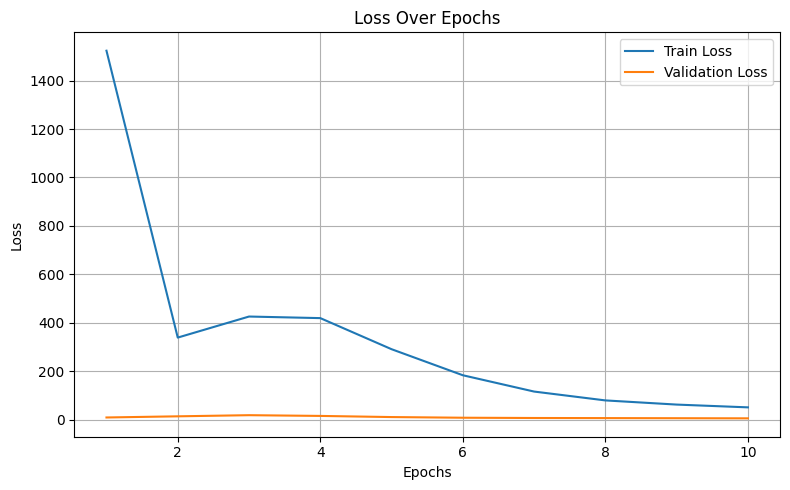

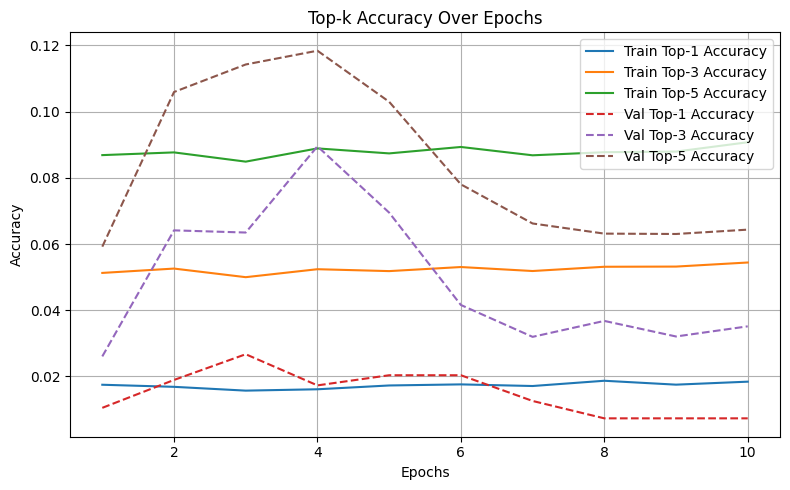

✅ GNN model saved to stage2_loop_gnn_model_no_CCE.pth.


In [2]:

# ========== Set Paths ==========
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_SAVE_PATH = 'stage2_loop_gnn_model_no_CCE.pth'

# ========== Load Data ==========
file_list = sorted([
    os.path.join(DATA_FOLDER, f)
    for f in os.listdir(DATA_FOLDER)
    if f.endswith('.csv')
])[:10]

train_size = int(0.8 * len(file_list))
train_files, val_files = file_list[:train_size], file_list[train_size:]

train_dataset = SatelliteDataset(train_files)
val_dataset = SatelliteDataset(val_files)

train_loader = PyGDataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"✅ Loaded {len(train_files)} training files and {len(val_files)} validation files.")

# ========== Load Stage 1 Model ==========
stage1_model = load_model(STAGE1_MODEL_PATH)

# ========== Build GNN Model ==========
input_dim = 3 + NUM_GATEWAYS * 3  # pos + visible + top3 + neighbor
gnn_model = Stage2GNN(
    input_dim=input_dim,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS,
    dropout=0.3,
    use_residual=True
)

optimizer_gnn = optim.Adam(gnn_model.parameters(), lr=0.001)

# ========== Training Configuration ==========
lambda_global = 1.0  # Global loss weight
lambda_gateway_fair = 0.1  # Gateway fairness weight
lambda_sat_coverage = 0.1  # Satellite coverage weight
lambda_sat_fair = 0.1  # Satellite fairness weight

# ========== Train ==========
results = train_model_with_mse(
    gnn_model=gnn_model,
    stage1_model=stage1_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer_gnn=optimizer_gnn,
    num_epochs=10,
    rounds=15,
    lambda_global=lambda_global,
    lambda_gateway_fair=lambda_gateway_fair,
    lambda_sat_coverage=lambda_sat_coverage,
    lambda_sat_fair=lambda_sat_fair
)

(train_losses, val_losses,
 train_top1_acc, train_top3_acc, train_top5_acc,
 val_top1_acc, val_top3_acc, val_top5_acc) = results

# ========== Plot ==========
plot_metrics(train_losses, val_losses,
             train_top1_acc, train_top3_acc, train_top5_acc,
             val_top1_acc, val_top3_acc, val_top5_acc)

# ========== Save Model ==========
torch.save(gnn_model.state_dict(), STAGE2_MODEL_SAVE_PATH)
print(f"✅ GNN model saved to {STAGE2_MODEL_SAVE_PATH}.")


In [7]:
import os
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model

from dataloader import prepare_input_for_gnn, build_graph_from_file
from utils import top_k_accuracy
from model import Stage2GNN

# Constants
NUM_GATEWAYS = 54  # Define this according to your setup

# Paths
DATA_FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
STAGE1_MODEL_PATH = 'stage_1_visible_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model_no_CCE.pth'

# Load models
stage1_model = load_model(STAGE1_MODEL_PATH)

input_dim = 3 + NUM_GATEWAYS * 3
gnn_model = Stage2GNN(input_dim=input_dim, sat_feature_dim=111,
                      neighbor_feature_dim=NUM_GATEWAYS, hidden_dim=256, output_dim=NUM_GATEWAYS)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# All files
file_list = sorted([os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')])

# Define test ranges
test_ranges = {
    "Train Range 0-5": (0, 5),
    "Train Range 5-10": (5, 10),
    "Test Range 100-105": (100, 105),
    #"Test Range 1000-1005": (1000, 1005),
    "Test Range 200-205": (200, 205)
}

# Function to evaluate one test set
def evaluate_test_set(name, start, end):
    print(f"\n===== Evaluating {name} (Files {start} to {end}) =====")
    test_files = file_list[start:end]
    test_graphs = [build_graph_from_file(f) for f in test_files if build_graph_from_file(f) is not None]
    test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

    total_top1, total_top3, total_top5, total_samples = 0, 0, 0, 0
    predictions = []

    with torch.no_grad():
        for data in test_loader:
            input_features = data.x[:, :57].cpu().numpy()
            stage1_preds = stage1_model.predict(input_features, verbose=0)
            top3_model1 = np.argsort(stage1_preds, axis=1)[:, -3:]

            binary_preds_model1 = np.zeros_like(stage1_preds)
            for i, idx in enumerate(top3_model1):
                binary_preds_model1[i, idx] = 1

            gnn_input = prepare_input_for_gnn(data, torch.tensor(binary_preds_model1, dtype=torch.float))
            preds = gnn_model(gnn_input.x, gnn_input.edge_index)

            total_top1 += top_k_accuracy(preds, data.y, k=1)
            total_top3 += top_k_accuracy(preds, data.y, k=3)
            total_top5 += top_k_accuracy(preds, data.y, k=5)
            total_samples += 1

            top1_pred = torch.topk(preds, k=1, dim=1).indices.squeeze().tolist()
            for i in range(len(data.y)):
                predictions.append([data.y[i].item(), top1_pred[i]])

    print(f"Top-1 Accuracy: {total_top1 / total_samples:.4f}")
    print(f"Top-3 Accuracy: {total_top3 / total_samples:.4f}")
    print(f"Top-5 Accuracy: {total_top5 / total_samples:.4f}")

    # Save predictions
    results_df = pd.DataFrame(predictions, columns=["Ground Truth", "Top-1 Prediction"])
    filename = f"test_results_{name.replace(' ', '_').replace('-', '_')}.csv"
    results_df.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")


# Run all  test sets
for name, (start, end) in test_ranges.items():
    evaluate_test_set(name, start, end)



===== Evaluating Train Range 0-5 (Files 0 to 5) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.0037
Top-3 Accuracy: 0.0375
Top-5 Accuracy: 0.0647
Saved predictions to test_results_Train_Range_0_5.csv

===== Evaluating Train Range 5-10 (Files 5 to 10) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.0067
Top-3 Accuracy: 0.0416
Top-5 Accuracy: 0.0703
Saved predictions to test_results_Train_Range_5_10.csv

===== Evaluating Test Range 100-105 (Files 100 to 105) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.0047
Top-3 Accuracy: 0.0322
Top-5 Accuracy: 0.0784
Saved predictions to test_results_Test_Range_100_105.csv

===== Evaluating Test Range 200-205 (Files 200 to 205) =====


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Top-1 Accuracy: 0.0111
Top-3 Accuracy: 0.0372
Top-5 Accuracy: 0.0688
Saved predictions to test_results_Test_Range_200_205.csv


CEll coverage

In [9]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model import Stage2GNN

# === Paths ===
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
data_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE2_MODEL_PATH = 'stage2_loop_gnn_model_no_CCE.pth'

# === Load Data ===
cells_df = pd.read_csv(cells_path)
original_df = pd.read_csv(data_file)

stage1_model = load_model(STAGE1_MODEL_PATH)

gnn_model = Stage2GNN(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE2_MODEL_PATH))
gnn_model.eval()

# === Prepare Graph ===
graph = build_graph_from_file(data_file)
data_loader = DataLoader([graph], batch_size=1)

# === Setup ===
unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
sat_to_indices = defaultdict(list)
for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
    sat_to_indices[feed_sat].append(row_idx)

satellite_to_gateway = {}
gateway_to_sats = defaultdict(list)
cell_to_gateways = {}  # index → [closest, second]
for idx, row in cells_df.iterrows():
    cell_to_gateways[idx] = [row["closest_gw_id"], row["second_closest_gw_id"]]

# === Model Inference ===
top1_preds = []
with torch.no_grad():
    for data in data_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

        binary_preds = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_indices):
            binary_preds[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
        gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
        top1_preds = torch.argmax(gnn_output, dim=1).cpu().numpy()

        for row_idx, gateway in enumerate(top1_preds):
            feed_sat = original_df.iloc[row_idx]["feed_sat"]
            satellite_to_gateway[feed_sat] = gateway
            gateway_to_sats[gateway].append(feed_sat)

# === Fair Cell Assignment (Greedy) ===
satellite_to_cells = defaultdict(list)
assigned_cells = set()
used_gateways = set()

for gw, sats in gateway_to_sats.items():
    nearby_cells = cells_df[
        (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
    ].index.tolist()

    if not sats or not nearby_cells:
        continue

    used_gateways.add(gw)
    sats = list(set(sats))  # Remove dups
    n_sats = len(sats)
    cell_chunks = np.array_split(nearby_cells, n_sats)

    for sat, chunk in zip(sats, cell_chunks):
        for cell in chunk:
            if cell not in assigned_cells:
                satellite_to_cells[sat].append(cell)
                assigned_cells.add(cell)

# === Summary ===
total_unique_sats = len(unique_sats)
total_cells = len(cells_df)
all_gateways = set(range(NUM_GATEWAYS))

assigned_sat_ids = set(satellite_to_cells.keys())
unassigned_sat_ids = sorted(set(feed_sat_to_id.keys()) - assigned_sat_ids)
unused_gateways = sorted(all_gateways - used_gateways)
unassigned_cells = sorted(set(cells_df.index) - assigned_cells)

# === Summary ===
print("\n=== Summary ===")
print(f"Unique Satellites: {total_unique_sats}")
print(f"Satellites With Assigned Cells: {len(assigned_sat_ids)} ({len(assigned_sat_ids) / total_unique_sats * 100:.2f}%)")
print(f"Satellites With No Assigned Cells: {len(unassigned_sat_ids)} ({len(unassigned_sat_ids) / total_unique_sats * 100:.2f}%)")

print(f"Gateways With Unassigned Cells: {len(unused_gateways)} ({len(unused_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Total Gateways: {NUM_GATEWAYS}")
print(f"Used Gateways: {len(used_gateways)} ({len(used_gateways) / NUM_GATEWAYS * 100:.2f}%)")
print(f"Unused Gateways: {unused_gateways}")

print(f"Assigned Cells: {len(assigned_cells)} / {total_cells} ({len(assigned_cells) / total_cells * 100:.2f}%)")
print(f"Unassigned Cells: {len(unassigned_cells)} ({len(unassigned_cells) / total_cells * 100:.2f}%)")

# === Export Results ===
# === Export Results ===
output_rows = []
all_sat_ids = sorted(feed_sat_to_id.keys())  # Include all satellites, not just assigned ones

for sat_feed_val in all_sat_ids:
    row_indices = sat_to_indices.get(sat_feed_val, [])
    predicted_gateways = [top1_preds[i] for i in row_indices if i < len(top1_preds)]
    most_common_gateway = Counter(predicted_gateways).most_common(1)[0][0] if predicted_gateways else None
    assigned = satellite_to_cells.get(sat_feed_val, [])

    # Convert np.int64 values to int
    assigned_clean = [int(cell) for cell in assigned]

    actual_gateway = original_df.loc[original_df["feed_sat"] == sat_feed_val, "gw"].iloc[0]
    actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat_feed_val, "cell_id"].tolist()

    output_rows.append({
        "unique_satellite_id": sat_feed_val,
        "predicted_gateway": most_common_gateway,
        "actual_gateway_id": actual_gateway,
        "assigned_cells": assigned_clean,
        "actual_cell_ids": actual_cell_ids
    })

output_df = pd.DataFrame(output_rows)
output_df.to_csv("satellite_to_cells_mapping_no_CCE.csv", index=False)

# === Output preview ===
print("\n=== Output File Preview ===")
print(output_df.head())


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



=== Summary ===
Unique Satellites: 112
Satellites With Assigned Cells: 112 (100.00%)
Satellites With No Assigned Cells: 0 (0.00%)
Gateways With Unassigned Cells: 31 (57.41%)
Total Gateways: 54
Used Gateways: 23 (42.59%)
Unused Gateways: [0, 3, 5, 6, 8, 11, 12, 13, 19, 22, 23, 25, 26, 27, 29, 30, 32, 34, 35, 36, 37, 38, 40, 41, 43, 45, 46, 47, 48, 52, 53]
Assigned Cells: 3289 / 4569 (71.99%)
Unassigned Cells: 1280 (28.01%)

=== Output File Preview ===
   unique_satellite_id  predicted_gateway  actual_gateway_id  \
0                    5                 39                  2   
1                    7                 31                 34   
2                    8                 16                 29   
3                   28                 31                  2   
4                   29                 51                 21   

                                      assigned_cells  \
0  [87, 122, 139, 149, 165, 255, 309, 382, 403, 5...   
1  [1157, 1172, 1220, 1241, 1244, 1250, 1277, 1

In [11]:
from collections import defaultdict

# === 1. Number of cells per satellite ===
cells_per_satellite = {sat: len(cells) for sat, cells in satellite_to_cells.items()}

# Optional: convert to DataFrame for easier sorting or export
cells_per_sat_df = pd.DataFrame(list(cells_per_satellite.items()), columns=["satellite_id", "num_cells"])
print("\n Number of Cells per Satellite (Top 5):")
print(cells_per_sat_df.sort_values(by="num_cells", ascending=False).head())

# === 2. Number of cells per gateway ===
cells_per_gateway = defaultdict(int)

for cell_id, row in cells_df.iterrows():
    closest = row["closest_gw_id"]
    second = row["second_closest_gw_id"]
    cells_per_gateway[closest] += 1
    cells_per_gateway[second] += 1  # Optional: count second gateway as partial coverage

# Convert to DataFrame
cells_per_gw_df = pd.DataFrame(list(cells_per_gateway.items()), columns=["gateway_id", "num_cells_linked"])
print("\n Number of Cells per Gateway (Top 5):")
print(cells_per_gw_df.sort_values(by="num_cells_linked", ascending=False).head())

# === 3. Number of satellites per gateway ===
sats_per_gateway = {gw: len(set(sats)) for gw, sats in gateway_to_sats.items()}
sats_per_gw_df = pd.DataFrame(list(sats_per_gateway.items()), columns=["gateway_id", "num_sats_assigned"])
print("\n Number of Satellites per Gateway (Top 5):")
print(sats_per_gw_df.sort_values(by="num_sats_assigned", ascending=False).head())



 Number of Cells per Satellite (Top 5):
     satellite_id  num_cells
105          1546        171
106          1501        167
111           325        165
108          1411        144
107           485        126

 Number of Cells per Gateway (Top 5):
    gateway_id  num_cells_linked
26        11.0               337
25        10.0               322
5         12.0               294
23        51.0               281
14        38.0               279

 Number of Satellites per Gateway (Top 5):
    gateway_id  num_sats_assigned
0            4                 22
4           16                 17
3           51                 15
7           21                 12
11          10                 10


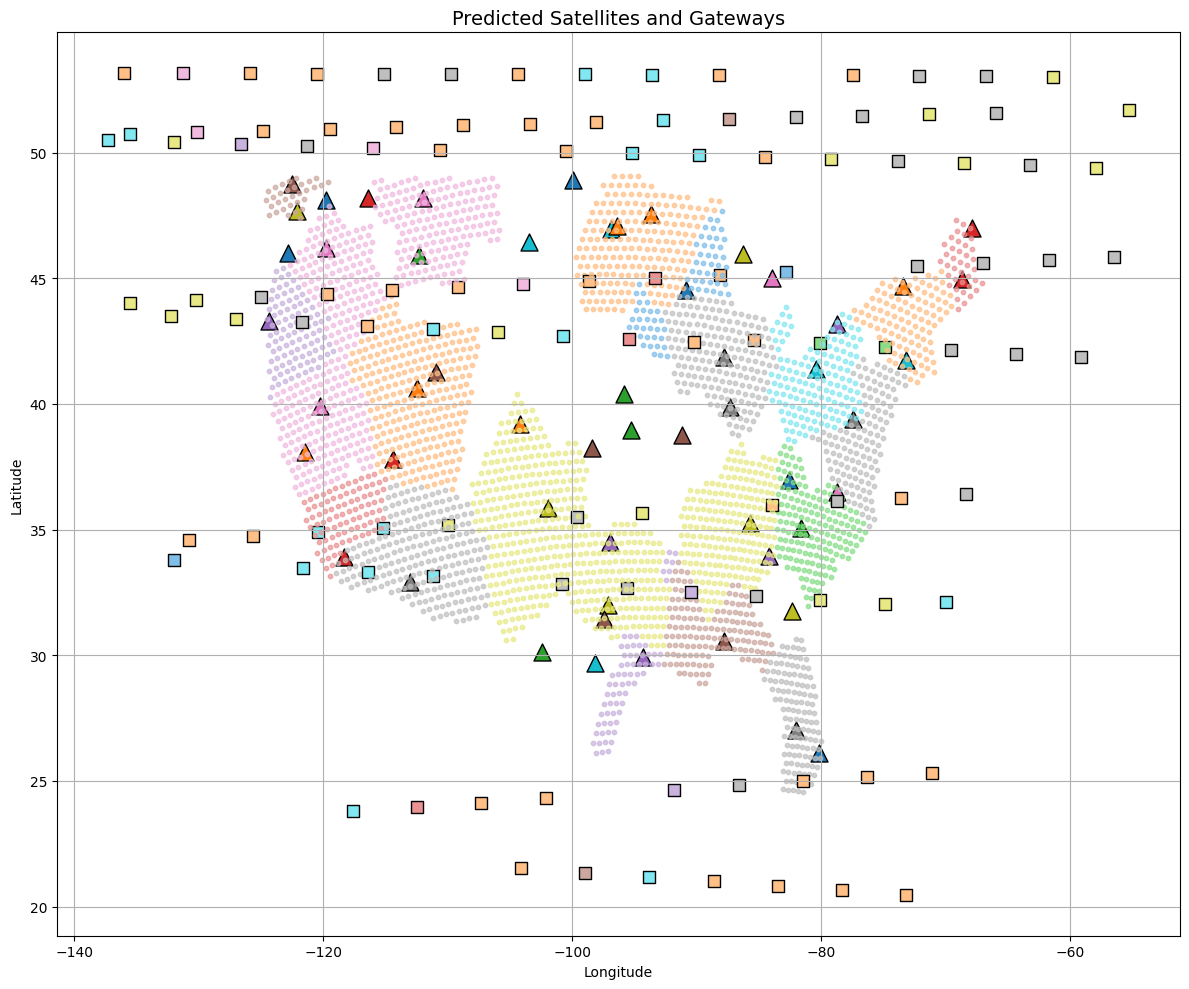

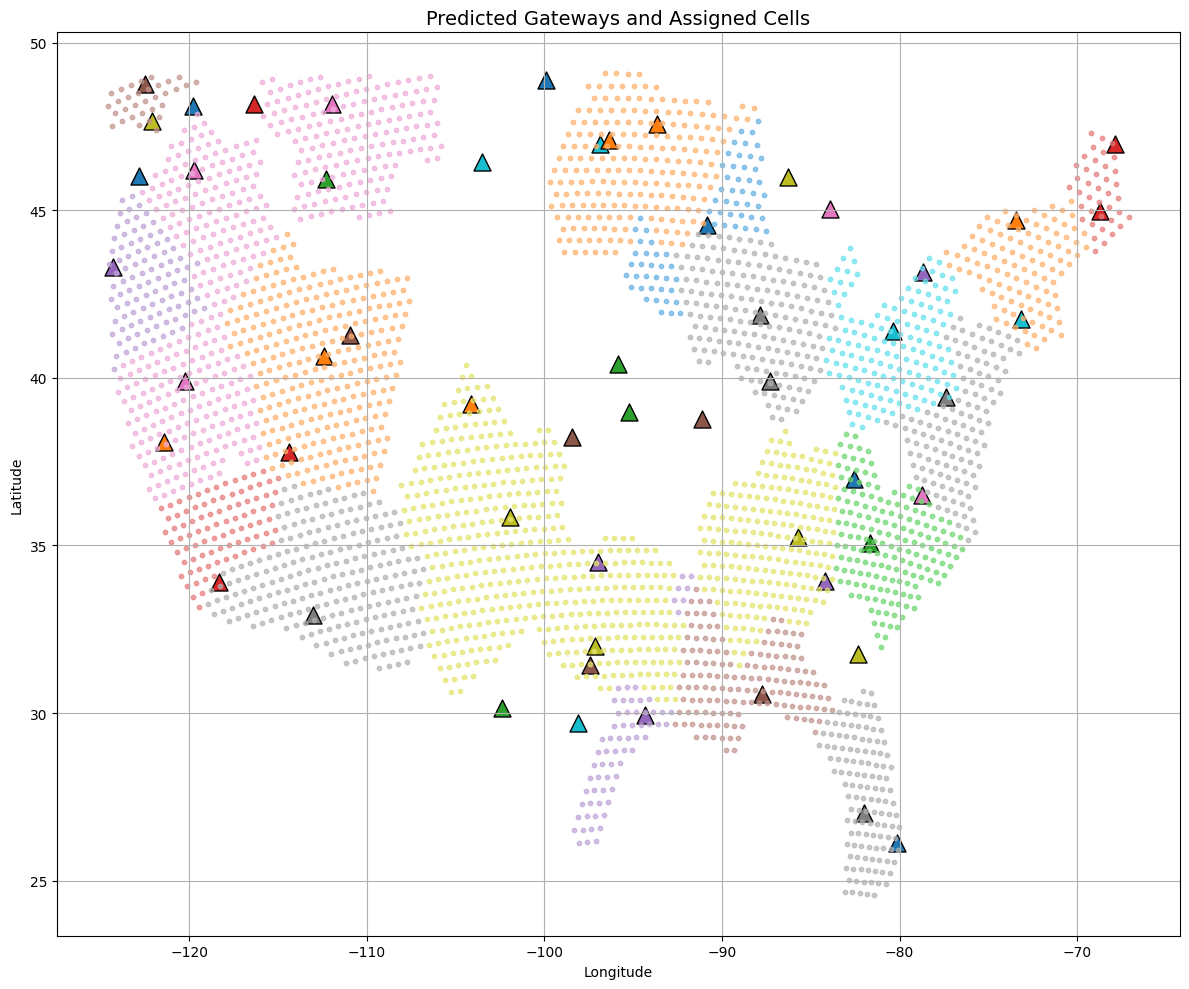

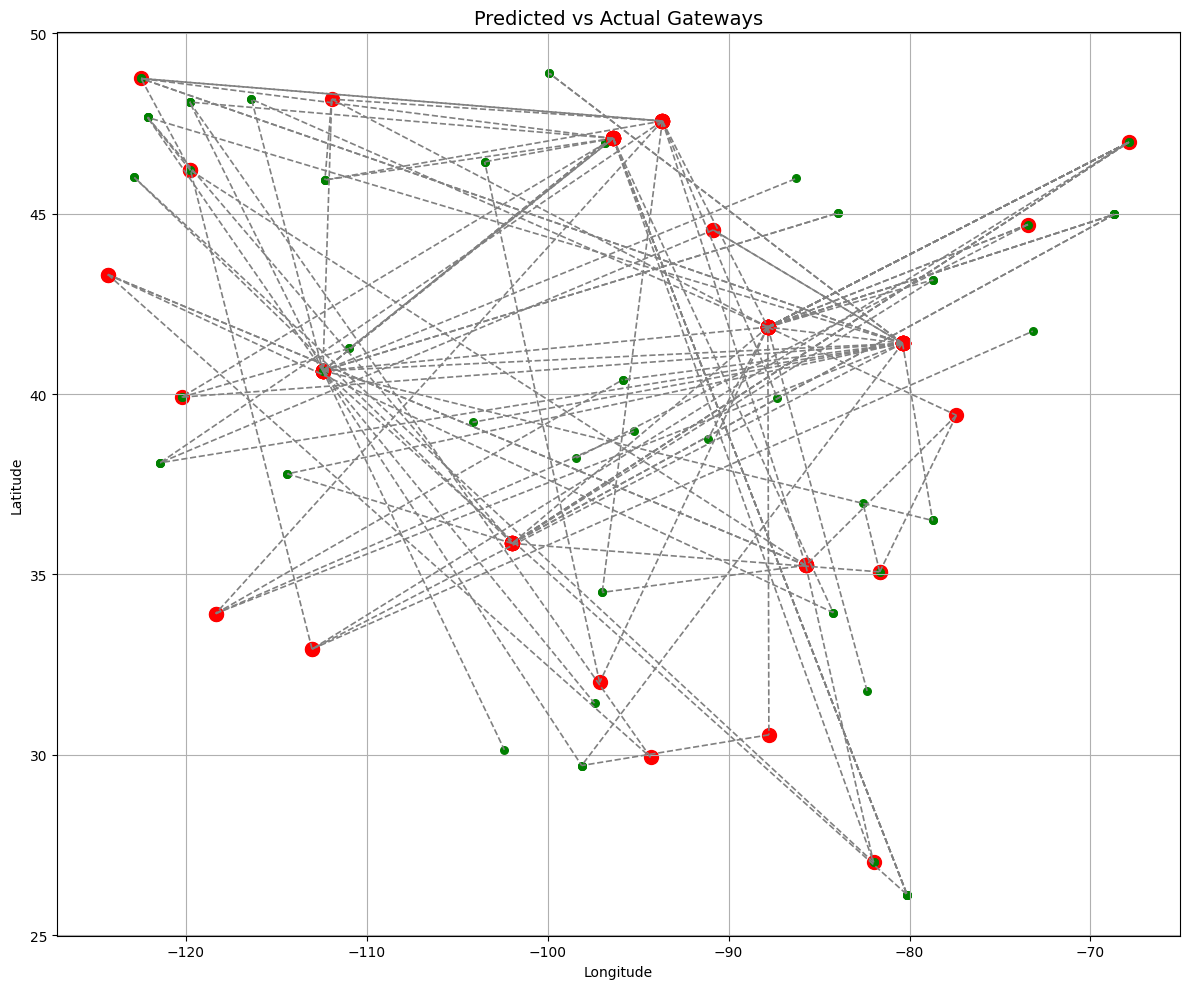

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# === Load Data ===
mapping_df = pd.read_csv("satellite_to_cells_mapping_no_CCE.csv")
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\df_gw.csv")
sat_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv")
sat_df = sat_df.drop_duplicates(subset='feed_sat')

# === Setup Color Map ===
NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)

gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

# === Helper: Lighter version of color ===
def lighten_color(color, amount=0.5):
    import colorsys
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    r, g, b = colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)
    return r, g, b

# === Parse list-like column ===
def parse_cells(cell_str):
    if isinstance(cell_str, str):
        return list(map(int, eval(cell_str)))
    return []

mapping_df['assigned_cells'] = mapping_df['assigned_cells'].apply(parse_cells)

# === Map 1: Predicted Satellites & Gateways ===
plt.figure(figsize=(12, 10))
for _, row in gw_df.iterrows():
    gw_id = row['gw_id']
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=150)

for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    sat_id = row['unique_satellite_id']
    color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.5)
    sat_row = sat_df[sat_df['feed_sat'] == sat_id]
    if not sat_row.empty:
        lng, lat = sat_row.iloc[0][['Longitude', 'Latitude']]
        plt.scatter(lng, lat, marker='s', c=[color], edgecolor='black', s=80)

    for cell_idx in row['assigned_cells']:
        lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
        plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

plt.title("Predicted Satellites and Gateways", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map1_predicted_satellites_and_gateways.png", dpi=300)
plt.show()

# === Map 2: Predicted Gateways & Assigned Cells ===
plt.figure(figsize=(12, 10))
for _, row in gw_df.iterrows():
    gw_id = row['gw_id']
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=150)

for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    color = lighten_color(gateway_color_map.get(pred_gw, 'gray'), amount=0.4)
    for cell_idx in row['assigned_cells']:
        lng, lat = cells_df.loc[cell_idx, ['lng', 'lat']]
        plt.scatter(lng, lat, c=[color], s=10, alpha=0.7)

plt.title("Predicted Gateways and Assigned Cells", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map2_predicted_gateways_and_cells.png", dpi=300)
plt.show()

# === Map 3: Predicted vs Actual Gateways ===
plt.figure(figsize=(12, 10))
for _, row in mapping_df.iterrows():
    pred_gw = row['predicted_gateway']
    actual_gw = row['actual_gateway_id']

    pred_gw_row = gw_df[gw_df['gw_id'] == pred_gw]
    actual_gw_row = gw_df[gw_df['gw_id'] == actual_gw]

    if not pred_gw_row.empty and not actual_gw_row.empty:
        pred_lng, pred_lat = pred_gw_row.iloc[0][['longitude', 'latitude']]
        act_lng, act_lat = actual_gw_row.iloc[0][['longitude', 'latitude']]

        plt.scatter(pred_lng, pred_lat, color='red', s=100, label='Predicted Gateway')
        plt.scatter(act_lng, act_lat, color='green', s=30, label='Actual Gateway')
        plt.plot([pred_lng, act_lng], [pred_lat, act_lat], linestyle='--', color='gray', linewidth=1.2)

plt.title("Predicted vs Actual Gateways", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("map3_predicted_vs_actual_gateways.png", dpi=300)
plt.show()


seems bad, lets rey coverage

In [6]:
import os
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import DataLoader
from tensorflow.keras.models import load_model
from collections import defaultdict, Counter

from dataloader import build_graph_from_file, prepare_input_for_gnn, NUM_GATEWAYS
from model3 import Stage2GNNPlus

# === Paths ===
cells_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
data_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data\file_data_00_00_00.csv"
STAGE1_MODEL_PATH = 'stage_1_model.h5'
STAGE3_MODEL_PATH = 'stage3_multilabel_model.pth'

# === Load data ===
cells_df = pd.read_csv(cells_path)
original_df = pd.read_csv(data_file)

# === Load models ===
stage1_model = load_model(STAGE1_MODEL_PATH)
gnn_model = Stage2GNNPlus(
    input_dim=3 + NUM_GATEWAYS * 3,
    sat_feature_dim=111,
    neighbor_feature_dim=NUM_GATEWAYS,
    hidden_dim=256,
    output_dim=NUM_GATEWAYS
)
gnn_model.load_state_dict(torch.load(STAGE3_MODEL_PATH))
gnn_model.eval()

# === Prepare graph ===
graph = build_graph_from_file(data_file)
data_loader = DataLoader([graph], batch_size=1)

# === Setup ===
unique_sats = original_df['feed_sat'].drop_duplicates().reset_index(drop=True)
feed_sat_to_id = {sat: idx for idx, sat in enumerate(unique_sats)}
sat_to_indices = defaultdict(list)
for row_idx, feed_sat in enumerate(original_df["feed_sat"]):
    sat_to_indices[feed_sat].append(row_idx)

satellite_to_gateways = defaultdict(list)
gateway_to_sats = defaultdict(list)
cell_to_gateways = {idx: [row["closest_gw_id"], row["second_closest_gw_id"]] for idx, row in cells_df.iterrows()}

# === Inference ===
with torch.no_grad():
    for data in data_loader:
        input_features = data.x[:, :57].cpu().numpy()
        stage1_preds = stage1_model.predict(input_features, verbose=0)
        top3_indices = np.argsort(stage1_preds, axis=1)[:, -3:]

        binary_preds = np.zeros_like(stage1_preds)
        for i, idx in enumerate(top3_indices):
            binary_preds[i, idx] = 1

        gnn_input = prepare_input_for_gnn(data, torch.from_numpy(binary_preds).float())
        gnn_output = gnn_model(gnn_input.x, gnn_input.edge_index)
        probs = torch.sigmoid(gnn_output)
        preds_bin = (probs > 0.5).int().cpu().numpy()

        for row_idx, pred_row in enumerate(preds_bin):
            feed_sat = original_df.iloc[row_idx]["feed_sat"]
            pred_gateways = np.where(pred_row == 1)[0].tolist()
            satellite_to_gateways[feed_sat] = pred_gateways
            for gw in pred_gateways:
                gateway_to_sats[gw].append(feed_sat)

# === Cell assignment ===
satellite_to_cells = defaultdict(list)
assigned_cells = set()
used_gateways = set()

for gw, sats in gateway_to_sats.items():
    nearby_cells = cells_df[
        (cells_df["closest_gw_id"] == gw) | (cells_df["second_closest_gw_id"] == gw)
    ].index.tolist()
    if not sats or not nearby_cells:
        continue

    used_gateways.add(gw)
    sats = list(set(sats))
    chunks = np.array_split(nearby_cells, len(sats))
    for sat, chunk in zip(sats, chunks):
        for cell in chunk:
            if cell not in assigned_cells:
                satellite_to_cells[sat].append(cell)
                assigned_cells.add(cell)

# === Summary ===
total_unique_sats = len(unique_sats)
total_cells = len(cells_df)
all_gateways = set(range(NUM_GATEWAYS))

assigned_sat_ids = set(satellite_to_cells.keys())
unassigned_sat_ids = sorted(set(feed_sat_to_id.keys()) - assigned_sat_ids)
unused_gateways = sorted(all_gateways - used_gateways)
unassigned_cells = sorted(set(cells_df.index) - assigned_cells)

print("\n=== Summary (Model 3 with multi-label prediction) ===")
print(f"🛰️ Satellites: {total_unique_sats} | Assigned: {len(assigned_sat_ids)} | Unassigned: {len(unassigned_sat_ids)}")
print(f"📡 Gateways: Used: {len(used_gateways)} / {NUM_GATEWAYS} | Unused: {unused_gateways}")
print(f"📍 Cells Assigned: {len(assigned_cells)} / {total_cells} | Coverage: {len(assigned_cells)/total_cells*100:.2f}%")

# === Save mapping ===
output_rows = []
for sat in sorted(feed_sat_to_id.keys()):
    assigned = satellite_to_cells.get(sat, [])
    assigned_clean = [int(cell) for cell in assigned]
    actual_gateway = original_df.loc[original_df["feed_sat"] == sat, "gw"].iloc[0]
    actual_cell_ids = original_df.loc[original_df["feed_sat"] == sat, "cell_id"].tolist()
    output_rows.append({
        "unique_satellite_id": sat,
        "predicted_gateways": satellite_to_gateways.get(sat, []),
        "actual_gateway_id": actual_gateway,
        "assigned_cells": assigned_clean,
        "actual_cell_ids": actual_cell_ids
    })

output_df = pd.DataFrame(output_rows)
output_df.to_csv("model3_satellite_to_cells_mapping.csv", index=False)

print("\n✅ Results saved to model3_satellite_to_cells_mapping.csv")
print("📋 Preview:")
print(output_df.head())


ImportError: cannot import name 'Stage2GNNPlus' from 'model3' (c:\Users\aruna\Satelite_Network\src\model3.py)